In [1]:
'''
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference: "3_mnist_from_scratch from", "docker run -it -p 8888:8888 gcr.io/tensorflow/tensorflow"
https://github.com/michael-iuzzolino/CIFAR_reader
'''
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module
from CIFAR_reader import CIFAR_reader

In [2]:
cifar = CIFAR_reader(one_hot=True, verbose=True, img_size=32, num_classes=10, augment=False)

Checking for CIFAR data...
Extracting Data...
Unpacking data...
Loading training batch 1 of 5...
Loading training batch 2 of 5...
Loading training batch 3 of 5...
Loading training batch 4 of 5...
Loading training batch 5 of 5...
Loading testing batch 1 of 1...


In [3]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
BATCH_SIZE = 128
N_CHANNELS = 3
N_LABELS = 10
SEED = 32

training_data = cifar.train
training_labels = cifar.labels
train_data = training_data['data']
train_labels = training_data['labels']

testing_data = cifar.test
test_data = testing_data['data']
test_data = np.float32(test_data)
test_labels = testing_data['labels']
test_labels = np.float32(test_labels)

# convert train and test data values from [0, 255] to [-0.5, 0.5]
N_TRAIN_IMAGE = len(train_data)
train_data = (train_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
train_data = train_data.reshape(N_TRAIN_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

N_TEST_IMAGE = len(test_data)
test_data = (test_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
test_data = test_data.reshape(N_TEST_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

#print("train_data[0]:", train_data[0])
#print("test_data[0]:", test_data[0])

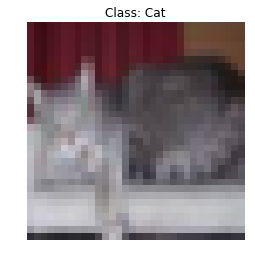

In [4]:
cifar.preview_data(data_set="training")

In [5]:
print (train_data.shape)
print (train_labels.shape)
print (test_data.shape)
print (test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [6]:
VALIDATION_SIZE = 10000

train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_data = np.float32(train_data)
train_labels = train_labels[VALIDATION_SIZE:]
train_size = len(train_data)
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_data = np.float32(validation_data)
validation_labels = train_labels[:VALIDATION_SIZE]
validation_size = len(validation_data)

print('train_data.shape', train_data.shape)
print('validation_data.shape', validation_data.shape)
print('train_data size:', train_size)
print('validation_data size:', validation_size)
#print('validation_data:', validation_data)
#print('validation_labels: ', validation_labels)

N_TRAIN_IMAGE = train_size
print("N_TRAIN_IMAGE: ", N_TRAIN_IMAGE)

train_data.shape (40000, 32, 32, 3)
validation_data.shape (10000, 32, 32, 3)
train_data size: 40000
validation_data size: 10000
N_TRAIN_IMAGE:  40000


In [7]:
import tensorflow as tf

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, N_LABELS))

train_all_data_node = tf.constant(train_data)
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
  tf.truncated_normal([10, 10, N_CHANNELS, 32],  # 5x5 kernel, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([10, 10, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, N_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[N_LABELS]))

print('Variables Initialized')

Variables Initialized


In [8]:
def model(data, train=False):

    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1], #[image index, y, x, depth]
                        padding='SAME')

    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    pool = tf.nn.max_pool(relu,
                          ksize=[1, 4, 4, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Fully connected layers
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the 
    # '+' operation automatically broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED) # drop out rate 50%
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Model defined')

Model defined


In [9]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
loss += 5e-4 * regularizers

batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)

# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)

# compute only by {eval()} method.
train_all_data_prediction = tf.nn.softmax(model(train_all_data_node))
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Training computation: logits + cross-entropy loss done')

Training computation: logits + cross-entropy loss done


In [10]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

In [11]:
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# batch data
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = sess.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print(batch_data.shape)
print(batch_labels.shape)
print('Run graph done.')

(128, 32, 32, 3)
(128, 10)
Run graph done.


In [12]:
print(predictions[0])

[  2.30611849e-10   1.11723393e-05   3.11259276e-18   7.73865182e-16
   8.28149438e-10   5.81399604e-07   4.76680258e-11   9.83323157e-01
   4.96903578e-14   1.66650619e-02]


In [13]:
# The highest probability in the first entry.
print('First prediction', np.argmax(predictions[0]))
print(predictions.shape)
print('All predictions', np.argmax(predictions, 1))

First prediction 7
(128, 10)
All predictions [7 4 5 1 7 5 6 1 0 7 5 0 5 5 5 4 5 4 7 7 7 2 5 1 5 5 1 0 5 7 7 9 5 9 7 9 5
 5 7 7 5 5 0 0 5 7 7 5 5 2 5 5 5 5 5 7 1 1 5 5 7 4 5 7 7 7 5 5 5 2 0 7 7 5
 7 0 9 5 5 7 5 7 4 0 9 9 4 5 5 5 5 5 5 5 6 5 6 9 5 4 5 7 4 7 9 8 5 0 7 7 7
 7 5 7 5 6 1 2 0 5 8 0 7 4 7 9 5 9]


In [14]:
print('Batch labels', np.argmax(batch_labels, 1))

Batch labels [1 6 6 8 8 3 4 6 0 6 0 3 6 6 5 4 8 3 2 6 0 3 1 4 0 6 6 2 7 6 9 0 4 5 7 1 6
 7 9 1 7 7 8 0 3 7 4 7 3 1 0 4 6 6 1 4 9 2 6 4 5 0 4 6 0 8 3 4 8 8 3 9 5 7
 1 9 4 7 9 1 9 7 5 2 7 3 4 8 8 2 1 5 9 2 7 8 8 6 8 8 1 3 8 8 5 4 7 1 6 6 1
 6 1 6 7 0 4 6 9 5 8 7 1 9 0 3 3 7]


In [15]:
def get_accuracy(predictions, labels):
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    accuracy = float(correct) / float(total)
    accuracy_fig = ""
    accuracy_fig = str(correct)
    accuracy_fig += (" of ")
    accuracy_fig += str(total)
    return accuracy, accuracy_fig

print('get_accuracy defined')

get_accuracy defined


In [16]:
validation_accuracy, validation_accuracy_fig = get_accuracy(validation_prediction.eval(), validation_labels)
print('validation_prediction.shape', validation_prediction.shape)
print('Validation accuracy: %.6f%% (%s)' %  (validation_accuracy * 100, validation_accuracy_fig))

validation_prediction.shape (10000, 10)
Validation accuracy: 12.980000% (1298 of 10000)


In [ ]:
test_accuracy, test_accuracy_fig = get_accuracy(test_prediction.eval(), test_labels)
print('test_prediction', test_prediction.shape)
print('Test accuracy: %.8f (%s)' % (test_accuracy, test_accuracy_fig))

test_prediction (10000, 10)
Test accuracy: 0.12920000 (1292 of 10000)


In [ ]:
#steps = train_size
steps = 2000
for step in range(steps):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
    _, l, lr, predictions = sess.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    
    if step % 5 == 0:
        print('Step %d of %d' % (step, steps))
        validation_accuracy, validation_accuracy_fig = get_accuracy(
              validation_prediction.eval(), validation_labels)
        print(validation_prediction.shape)
        print('Validation accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
              (validation_accuracy * 100, validation_accuracy_fig, l, lr))
        
        print(train_all_data_prediction.shape)
        train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
        print('Train accuracy: %.8f (%s)' % (train_accuracy, train_accuracy_fig))
        #feed_train_all_data_dict = {train_all_data_node: train_data}
        #train_accuracy, train_accuracy_fig = get_accuracy(
         #     train_all_data_prediction.eval(feed_dict=feed_train_all_data_dict), 
         #   train_labels)
        
        #train_accuracy, train_accuracy_fig = get_accuracy(
        #      train_all_data_prediction.eval(), train_labels)
        
        #print('Train accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
         #     (train_accuracy * 100, train_accuracy_fig, l, lr))

Step 0 of 2000


In [ ]:
test_accuracy, test_accuracy_fig = get_accuracy(test_prediction.eval(), test_labels)
print('Test accuracy: %.8f (%s)' % (test_accuracy, test_accuracy_fig))

In [ ]:
train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
print('Train accuracy: %.8f (%s)' % (train_accuracy, train_accuracy_fig))